In [1]:
from tsai.all import *
computer_setup()

c:\Users\karll\miniconda3\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


os              : Windows-10-10.0.22621-SP0
python          : 3.9.13
tsai            : 0.3.5
fastai          : 2.7.11
fastcore        : 1.5.28
torch           : 1.13.1+cpu
cpu cores       : 6
threads per cpu : 2
RAM             : 15.9 GB
GPU memory      : [6.0] GB


# Load data 🔢

In [9]:
##Data needs to be of the format [length, features, sequence]
import sys, os
import pandas as pd

from Preprocessing.preprocessing import preprocessing


df = pd.read_csv('Data\Stock\StockBars\MSFT_Minute')
data_train, data_test ,s = preprocessing(df[:10000],sequence_length = 2, lag=1, TSAI = True, CLF = True)

X, y, splits = combine_split_data([data_train[0], data_test[0]],[data_train[1], data_test[1]])
print(torch.unique(y))

print(X.shape, y.shape)

tensor([0., 1.])
torch.Size([9995, 9, 2]) torch.Size([9995])


# XCM baseline 🧢

SuggestedLRs(valley=0.001737800776027143)

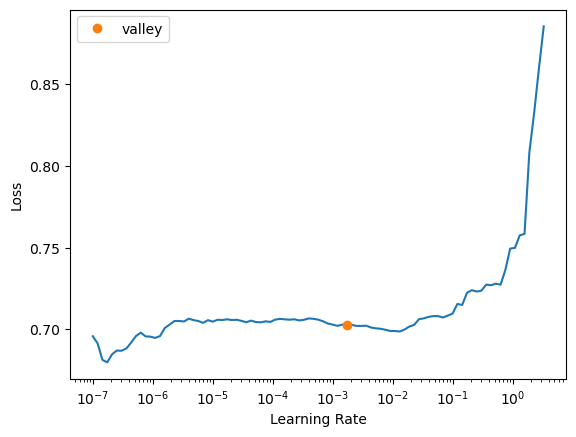

In [10]:
bs = 64
dsets = TSDatasets(X, y, splits=splits)
dls   = TSDataLoaders.from_dsets(dsets.train, dsets.valid, bs=bs)

model = XCMPlus(9, 2, dls.len)
learn = Learner(dls, model, loss_func=LabelSmoothingCrossEntropyFlat(), metrics=[RocAucBinary(), accuracy],  cbs=ShowGraphCallback2())
learn.lr_find()

epoch,train_loss,valid_loss,roc_auc_score,accuracy,time
0,0.694622,0.692852,0.493642,0.547094,00:02
1,0.694567,0.687900,0.528748,0.547094,00:02
2,0.694233,0.692375,0.513164,0.539078,00:02
3,0.694871,0.713235,0.509560,0.527054,00:02
4,0.694926,0.703357,0.498024,0.529058,00:02
5,0.695643,0.696804,0.497132,0.540080,00:02
6,0.696209,0.690230,0.507124,0.543086,00:02
7,0.692665,0.693832,0.503431,0.524048,00:02
8,0.692755,0.690162,0.507051,0.546092,00:02
9,0.689408,0.691799,0.519978,0.541082,00:02


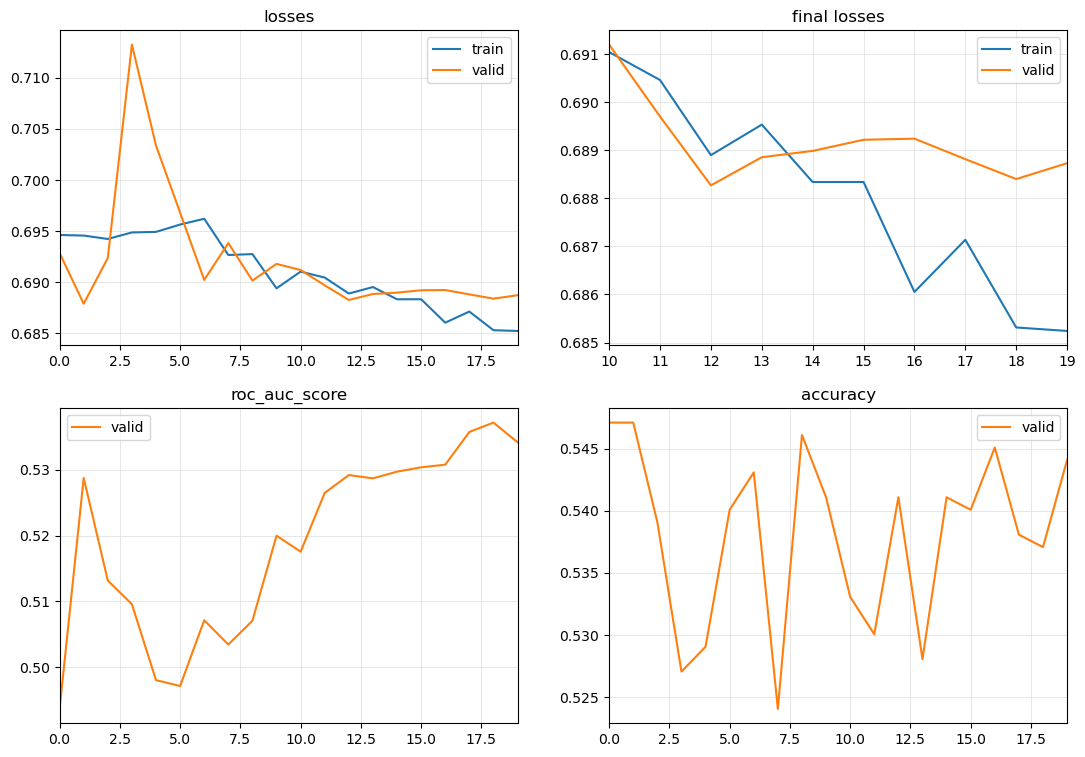


Elapsed time: 51.52936387062073


In [11]:
learn = Learner(dls, model, loss_func=LabelSmoothingCrossEntropyFlat(), metrics=[RocAucBinary(), accuracy],  cbs=ShowGraphCallback2())
start = time.time()
learn.fit_one_cycle(20, 5e-3)
print('\nElapsed time:', time.time() - start)

# Parameter tuning TODO

In [10]:
import optuna
from optuna.integration import FastAIPruningCallback

def objective(trial:optuna.Trial):
    
    # Define search space here. More info here https://optuna.readthedocs.io/en/stable/tutorial/10_key_features/002_configurations.html
    hidden_size = trial.suggest_categorical('hidden_size', [25, 50, 100, 200])
    bidirectional = trial.suggest_categorical('bidirectional', [True, False])
    rnn_layers = trial.suggest_categorical('rnn_layers', [1, 2, 4, 8])
    rnn_dropout = trial.suggest_float("rnn_dropout", 0.0, 0.5, step=.1) # search through all float values between 0.0 and 0.5 with 0.1 increment steps
    fc_dropout = trial.suggest_float("fc_dropout", 0.0, 0.5, step=.1) # search through all float values between 0.0 and 0.5 with 0.1 increment steps
    learning_rate = trial.suggest_float("learning_rate", 1e-6, 1e-2, log=True)  # search through all float values between 0.0 and 0.5 in log increment steps
    
    model =LSTM_FCNPlus(9, 2, dls.len,
                hidden_size=hidden_size,
                bidirectional=bidirectional,
                rnn_layers=rnn_layers,
                rnn_dropout= rnn_dropout,
                fc_dropout=fc_dropout)
    learn = Learner(dls, model, loss_func=LabelSmoothingCrossEntropyFlat(), metrics=[RocAucBinary(), accuracy],  cbs=FastAIPruningCallback(trial))

    with ContextManagers([learn.no_logging(), learn.no_bar()]): # [Optional] this prevents fastai from printing anything during training
        learn.fit_one_cycle(15, lr_max=learning_rate)

    # Return the objective value
    return learn.recorder.values[-1][3] # return the validation loss value of the last epoch 

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=8)

[I 2023-03-03 16:28:19,301] A new study created in memory with name: no-name-b266b70a-4810-4254-b21e-cf825a3202d7
[I 2023-03-03 16:37:47,901] Trial 0 finished with value: 0.5247725248336792 and parameters: {'hidden_size': 200, 'bidirectional': False, 'rnn_layers': 8, 'rnn_dropout': 0.4, 'fc_dropout': 0.1, 'learning_rate': 0.00032654031163745705}. Best is trial 0 with value: 0.5247725248336792.
[I 2023-03-03 16:39:18,468] Trial 1 finished with value: 0.530839204788208 and parameters: {'hidden_size': 50, 'bidirectional': False, 'rnn_layers': 2, 'rnn_dropout': 0.4, 'fc_dropout': 0.4, 'learning_rate': 0.0007846276287836207}. Best is trial 1 with value: 0.530839204788208.
[I 2023-03-03 16:42:00,996] Trial 2 finished with value: 0.5864509344100952 and parameters: {'hidden_size': 25, 'bidirectional': False, 'rnn_layers': 8, 'rnn_dropout': 0.2, 'fc_dropout': 0.30000000000000004, 'learning_rate': 0.00013599319822964813}. Best is trial 2 with value: 0.5864509344100952.
[I 2023-03-03 16:43:15,866